### Load dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATASET_DIRS = "./Datasets/dataset_small_balanced.pkl"

In [3]:
dataset = pd.read_pickle(DATASET_DIRS)

In [4]:
MAX_MONSTER_NUM = 1000
MONSTER_HP_COLUMNS = ["monster_hp_" + str(num) for num in range(1, MAX_MONSTER_NUM + 1)]
FEATURES = ["focus_damage", "aoe_damage", *MONSTER_HP_COLUMNS]
TARGET = ["attack_num"]

### Train test split

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
bins = np.linspace(dataset[TARGET].to_numpy().min(), dataset[TARGET].to_numpy().max(), 100, dtype=int)
Y_bin = np.digitize(dataset[TARGET].to_numpy(), bins)

In [7]:
train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True, stratify=Y_bin)

In [8]:
X_train, Y_train = train_set[FEATURES].to_numpy(), train_set[TARGET].to_numpy()
X_test, Y_test = test_set[FEATURES].to_numpy(), test_set[TARGET].to_numpy()

In [9]:
len(X_train), len(X_test)

(682500, 227500)

### Normalization

In [10]:
import joblib
from sklearn.preprocessing import MinMaxScaler

In [11]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = X_scaler.transform(X_test.astype(np.float32))

Y_scaler = MinMaxScaler()
Y_train_scaled = Y_scaler.fit_transform(Y_train.astype(np.float32))
Y_test_scaled = Y_scaler.transform(Y_test.astype(np.float32))

In [12]:
joblib.dump(Y_scaler, "./Save/Y_scaler.pkl")
joblib.dump(X_scaler, "./Save/X_scaler.pkl")

['./Save/X_scaler.pkl']

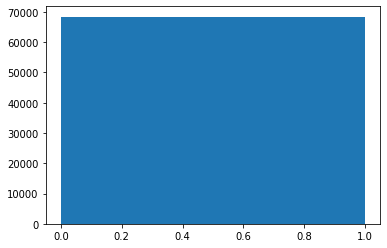

In [13]:
plt.hist(Y_train_scaled)
plt.show()

### Model

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MAE
from utilities import LearningRateFinder

In [15]:
def history_plot(history):
    x = list(range(len(history.history["loss"])))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.subplot(2, 1, 1)
    plt.title("loss")
    plt.plot(x, loss)
    plt.subplot(2, 1, 2)
    plt.title("val_loss")
    plt.plot(x, val_loss)
    
def losses_plot(Y_true, Y_pred):
    losses = MAE(Y_true, Y_pred)
    plt.scatter(Y_pred, losses)
    plt.show()
    
def prediction_distribution(pred):
    plt.hist(pred, bins=100)
    plt.show()

In [16]:
input_shape = [X_train.shape[1]]

In [17]:
class SequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.dense_1 = Dense(1024, activation=LeakyReLU())
        self.dense_2 = Dense(1, activation="relu")
        
    def call(self, inputs):
        output = self.dense_1(inputs)
        output = self.dense_2(output)
        
        return output

class NonSequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.dense_1 = Dense(16, activation="relu")
        self.dense_2 = Dense(1, activation="relu")
        
    def call(self, inputs):
        hps, damages = tf.split(inputs, [1000, 2], axis=1)
        output = self.dense_1(hps)
        output = tf.concat([output, damages], axis=1)
        output = self.dense_2(output)
        
        return output

In [21]:
# Save or load initial model, so every time, we start with the same init model
model = SequenceDense()
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")
# model.save_weights("./Save/Model_initial/model_1024")
model.load_weights("./Save/Model_initial/model_1024")

Train on 682500 samples
Epoch 1/20
682500/682500 [==============================] - 67s 97us/sample - loss: 0.4996
Epoch 2/20
682500/682500 [==============================] - 64s 93us/sample - loss: 0.4994
Epoch 3/20
682500/682500 [==============================] - 64s 94us/sample - loss: 0.4921s 
Epoch 4/20
682500/682500 [==============================] - 65s 96us/sample - loss: 0.3074
Epoch 5/20
682500/682500 [==============================] - 68s 99us/sample - loss: 0.1697
Epoch 6/20
682500/682500 [==============================] - 68s 100us/sample - loss: 0.1546
Epoch 7/20
682500/682500 [==============================] - 65s 95us/sample - loss: 0.1350
Epoch 8/20
682500/682500 [==============================] - 67s 99us/sample - loss: 0.1161
Epoch 9/20
682500/682500 [==============================] - 68s 99us/sample - loss: 0.1045
Epoch 10/20
682500/682500 [==============================] - 65s 95us/sample - loss: 0.0801
Epoch 11/20
682500/682500 [==============================] - 7

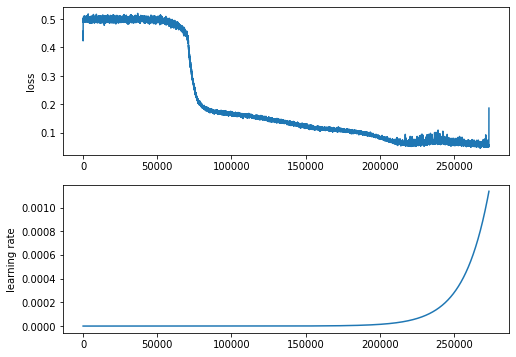

In [22]:
lr_finder = LearningRateFinder(model)
lr_finder.find((X_train_scaled, Y_train_scaled), start_lr=1e-10, epochs=20)
lr_finder.plot()

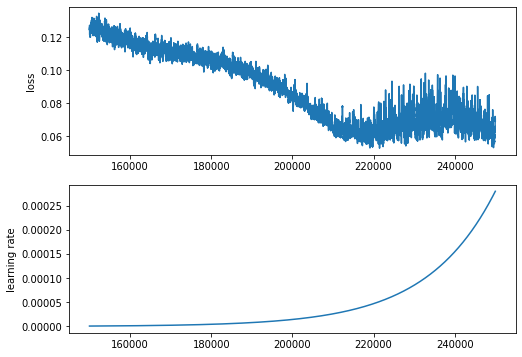

In [25]:
lr_finder.plot(start=150000, end=250000)

In [27]:
lr_finder.lrs[200000]

1.4364674e-05

Train on 546000 samples, validate on 136500 samples
Epoch 1/500
546000/546000 [==============================] - 58s 107us/sample - loss: 0.1182 - val_loss: 0.1070
Epoch 2/500
546000/546000 [==============================] - 60s 111us/sample - loss: 0.1002 - val_loss: 0.0961
Epoch 3/500
546000/546000 [==============================] - 51s 94us/sample - loss: 0.0884 - val_loss: 0.0853
Epoch 4/500
546000/546000 [==============================] - 50s 92us/sample - loss: 0.0773 - val_loss: 0.0707
Epoch 5/500
546000/546000 [==============================] - 52s 96us/sample - loss: 0.0671 - val_loss: 0.0614
Epoch 6/500
546000/546000 [==============================] - 54s 99us/sample - loss: 0.0581 - val_loss: 0.0537
Epoch 7/500
546000/546000 [==============================] - 54s 100us/sample - loss: 0.0509 - val_loss: 0.0474
Epoch 8/500
546000/546000 [==============================] - 54s 98us/sample - loss: 0.0457 - val_loss: 0.0424
Epoch 9/500
546000/546000 [==============================

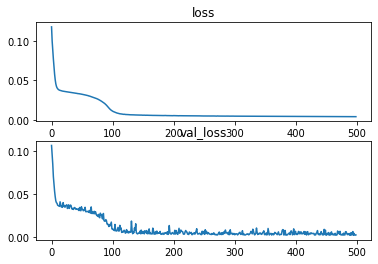

In [23]:
model = SequenceDense()
model.load_weights("./Save/Model_initial/model_1024")

model.compile(optimizer=Adam(learning_rate=lr_finder.lrs[180000]), loss="mae")
history = model.fit(X_train_scaled, Y_train_scaled, epochs=500, batch_size=32, validation_split=0.2, verbose=1)

history_plot(history)

In [ ]:
model.evaluate(X_test_scaled, Y_test_scaled, verbose=2)

In [ ]:
# Inbalance dataset is highly possible due to the following prediction distriburion.
pred = model.predict(X_train_scaled)
prediction_distribution(pred)

In [ ]:
plt.hist(Y_train_scaled)
plt.show()

In [ ]:
model.save_weights("./Save/Model_without_decay/model_1024")

In [ ]:
model = SequenceDense()
model.load_weights("./Save/Model_without_decay/model_1024")

In [ ]:
# Inbalance dataset is highly possible due to the following prediction distriburion.
pred = model.predict(X_train_scaled)
prediction_distribution(pred)

In [ ]:
losses_plot(Y_train_scaled, pred)